In [1]:
import pymongo
from pymongo import MongoClient
client = MongoClient('mongodb://127.0.0.1:27017')
db = client.sample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import RobustScaler

In [2]:

samples = pd.read_csv('../features collection/results/tot/tot_teams_vectors_weighted.csv')
samples = samples.drop(samples.columns[0], axis=1)
samples_log = samples.apply(np.log)
samples_log = samples_log.replace(-np.inf, 0)
samples_log = samples_log.fillna(0)
transformer = RobustScaler().fit(samples_log)
samples_scaled = pd.DataFrame(transformer.transform(samples_log), columns=list(samples))

In [3]:
# caricamento e normalizzazione dela variabile di target
def load_target(path):

    target = pd.read_csv(path)
    target = target.drop(target.columns[0], axis=1)
    target_log = target.apply(np.log)
    target_log = target_log.replace(-np.inf, 0)
    target_log = target_log.fillna(0)
    transformer = RobustScaler().fit(target_log)
    target_scaled = pd.DataFrame(transformer.transform(target_log), columns=['likes'])
    return target_scaled

In [4]:
# different target variables

target_set_nLike = load_target('../features collection/results/tot/teams_nlikes_target.csv')
target_set_nLikeNorm = load_target('../features collection/results/tot/teams_nlikesNormalized_target.csv')
target_set_rankLike = load_target('../features collection/results/tot/teams_rankLikes_target.csv')
target_set_rankLikeNorm = load_target('../features collection/results/tot/teams_rankLikesNormalized_target.csv')

# VIF

VIFs start at 1 and have no upper limit. A value of 1 indicates that there is no correlation between this independent variable and any others. VIFs between 1 and 5 suggest that there is a moderate correlation, but it is not severe enough to warrant corrective measures. VIFs greater than 5 represent critical levels of multicollinearity where the coefficients are poorly estimated, and the p-values are questionable.

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(X, thresh):

    #X - pandas dataframe
    
    variables = ['team_nusers',
        'team_degree',
        'team_degree_centrality',
        'team_betweenness_centrality',
        'team_closeness_centrality',
        'team_eigenvector_centrality',
        'team_pagerank',
        'team_avg_users_nshot',
        'team_avg_users_in_degree',
        'team_avg_users_out_degree',
        'team_avg_users_rank',
        'team_avg_users_diversity',
        'team_avg_users_nskills',
        'team_avg_users_nfollowers',
        'team_avg_users_nfollowings',       
        'team_avg_users_avg_shots_ranking',
        'team_avg_users_avg_shots_ntags',
        'team_avg_users_avg_shots_ncomments',
        'team_avg_users_avg_shots_nlikes',
        'team_avg_users_avg_shots_nviews',
        'team_avg_users_avg_shots_diversity'
       ]

    for i in np.arange(0, len(variables)):
        
        # Variance inflation factor measures how much the behavior (variance) of an independent variable is influenced, 
        # or inflated, by its interaction/correlation with the other independent variables.
        
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]
        #print(vif)
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            #print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc) +'\n')
            del variables[maxloc]
            
    return sorted(zip(map(lambda x: round(x, 4), vif), variables), reverse=False)
    

In [6]:
thresh = 5.0
print '\nRemaining variables sorted by VIF score, and tresh =',thresh
res = calculate_vif_(samples_scaled, thresh)
for elem in res:
    print elem


Remaining variables sorted by VIF score, and tresh = 5.0
(1.5018, 'team_eigenvector_centrality')
(1.5441, 'team_closeness_centrality')
(1.7944, 'team_avg_users_rank')
(2.0052, 'team_avg_users_out_degree')
(2.4625, 'team_betweenness_centrality')
(2.5271, 'team_avg_users_avg_shots_nviews')
(2.7471, 'team_degree')
(3.1146, 'team_avg_users_diversity')
(3.1183, 'team_avg_users_in_degree')
(3.1788, 'team_avg_users_avg_shots_ncomments')
(3.1948, 'team_avg_users_avg_shots_ranking')
(3.2611, 'team_avg_users_nskills')
(3.5364, 'team_avg_users_avg_shots_diversity')
(4.3221, 'team_nusers')
(4.8364, 'team_avg_users_nshot')


# Univariate Feature Selection

Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable. These methods are simple to run and understand and are in general particularly good for gaining a better understanding of data (but not necessarily for optimizing the feature set for better generalization). There are lot of different options for univariate selection.

For each feature, we plot the p-values for the univariate feature selection and the corresponding weights of an SVM. We can see that univariate feature selection selects the informative features and that these have larger SVM weights.

In [37]:
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
encoded_target = lab_enc.fit_transform(target_set_rankLikeNorm)

/home/simo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/simo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


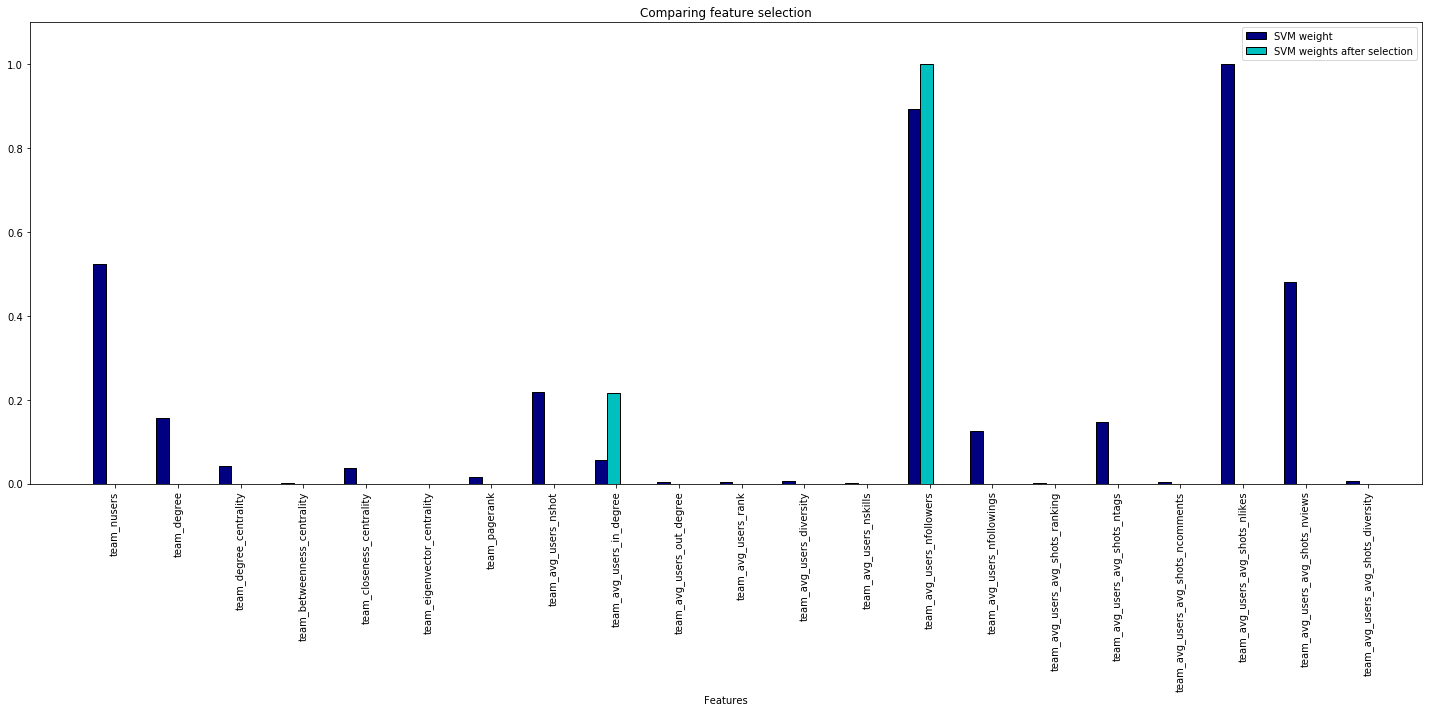

In [38]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn import svm
from sklearn.svm import SVR

X_indices = np.arange(samples_scaled.shape[-1])
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(samples_scaled, target_set_rankLikeNorm)

scores = -np.log10(selector.pvalues_)
scores /= scores.max()



'''
# plpt of p-values
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')'''

lista = zip(map(lambda x: round(x, 4), scores), list(samples_scaled))
sorted_list = sorted(zip(map(lambda x: round(x, 4), scores), list(samples_scaled)), reverse=True)
'''for elem in sorted_list:
    print elem'''


# Compare to the weights of an SVM
clf = svm.SVR(kernel='linear')
clf.fit(samples_scaled, encoded_target)

svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()

plt.bar(X_indices - .25, svm_weights, width=.2, label='SVM weight',
        color='navy', edgecolor='black')

clf_selected = svm.SVR(kernel='linear')
clf_selected.fit(selector.transform(samples_scaled), encoded_target)




svm_weights_selected = (clf_selected.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c',
        edgecolor='black')


plt.title("Comparing feature selection")
plt.xlabel('Features')


names = []
for elem in lista:
    names.append(elem[1])

plt.xticks(X_indices, names)
plt.xticks(rotation=90)
plt.axis()
plt.legend(loc='upper right')

fig = plt.gcf()
fig.set_size_inches(20,10)
plt.ylim(0,1.1)

plt.tight_layout()
plt.savefig('ufs.pdf')
plt.show()


In the total set of features, only the 2 first ones are significant. We can see that they have the highest score with univariate feature selection. The SVM assigns a large weight to one of these features, but also Selects many of the non-informative features. Applying univariate feature selection before the SVM increases the SVM weight attributed to the significant features, and will thus improve classification.

In [30]:
print selector.transform(samples_scaled)[0]

[-0.181  0.193]
